In [ ]:
!pip install tensorflow
!pip install matplotlib
!pip install pandas
!pip install seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Mounted at /content/MyDrive/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
E_LENGTH = 100
D_LENGTH = 100
B_SIZE = 64
BUF_SIZE = B_SIZE*4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/convs.csv")
#train.drop(['source'],axis=1,inplace=True)
mask = (train['english'].str.len()>20) & (train['english'].str.len()<200)
train = train.loc[mask]
train.head()

,Unnamed: 0,english,hindi
0,0,I have 21 4 star places can you tell me what a...,मेरे पास 21 4 स्टार स्थल हैं क्या आप मुझे बता ...
1,1,Yes please book that for 4 people for 4 nights...,"हाँ, कृपया इसे शनिवार से लेकर चार रातों के लिए..."
2,2,That's all I need thank you so much.,बस इतना है कि मुझे बहुत धन्यवाद है।
3,3,I need a place to stay that has free wifi. I d...,मुझे ठहरने के लिए एक स्थान की जरूरत है कि निःश...
4,4,I would like to visit a college. I'm not sure ...,मैं एक कॉलेज का दौरा करना चाहता हूँ। मैं निश्च...


In [ ]:
len(train)

4922

In [ ]:
X = train.iloc[:, :-1]
y = train.iloc[:, -1]

# split the dataset
eng_train, eng_test, hin_train, hin_test = train_test_split(
    X, y, test_size=0.05, random_state=0)

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
eng = eng_train['english']
hind = hin_train
eng = eng.apply(lambda x: "<SOS> " + str(x) + " <EOS>")
hind = hind.apply(lambda x: "<SOS> "+ x + " <EOS>")

In [ ]:
eng

1780                                                                                                              <SOS> Yes can I get the address and phone number please? <EOS>
4529    <SOS> You've got 2 choices in the north for cheap places to eat: Royal Spice serves Indian food and Da Vinci Pizzeria serves Italian food. Which would you prefer? <EOS>
4028                                                                                                                                  <SOS> What museums are in Cambridge? <EOS>
2445                                                                 <SOS> I can give you all kinds of information as well as book a ticket. Where are you going and when? <EOS>
1015                                                  <SOS> It is in the North area the address is Cambridge Passenger Cruisers Jubilee House. Phone number is 01223902091 <EOS>
                                                                                          ...                      

In [ ]:
hin_train

1780                                                                                                      क्या मैं कृपया पता और फोन नंबर प्राप्त कर सकता हूँ?
4529    उत्तर में आपको खाने के लिए सस्ती जगहों के लिए दो विकल्प मिलते हैंः रॉयल स्पाइस भारतीय खाना और दा विंचि पिज़ेरिया इटालियन खाना। आप किस को पसंद करेंगे?
4028                                                                                                                      कैम्ब्रिज में कौन-सी संग्रहालय हैं?
2445                                                          मैं आपको हर प्रकार की जानकारी दे सकता हूँ और टिकट भी बुक कर सकता हूँ। आप कहाँ जा रहे हैं और कब?
1015                                                          यह उत्तरी क्षेत्र में है पता है कैम्ब्रिज यात्री क्रूज़र्स जयंती हाउस। फोन नंबर 01223902091 है।
                                                                                ...                                                                          
4936                                                

In [ ]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
eng_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
hind_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = filters, oov_token=oov_token)
eng_tokenizer.fit_on_texts(eng)
hind_tokenizer.fit_on_texts(hind)
inputs = eng_tokenizer.texts_to_sequences(eng)
targets = hind_tokenizer.texts_to_sequences(hind)

In [ ]:
ENCODER_VOCAB = len(eng_tokenizer.word_index) + 1
DECODER_VOCAB = len(hind_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

2527 3517


In [ ]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=E_LENGTH, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=D_LENGTH, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUF_SIZE).batch(B_SIZE)

In [ ]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)

        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x

In [ ]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

In [ ]:
@keras.saving.register_keras_serializable()
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
EPOCHS = 100

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
      step = tf.cast(step, dtype=tf.float32)  # Cast step to float32
      arg1 = tf.math.rsqrt(step)
      arg2 = step * (self.warmup_steps ** -1.5)

      return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

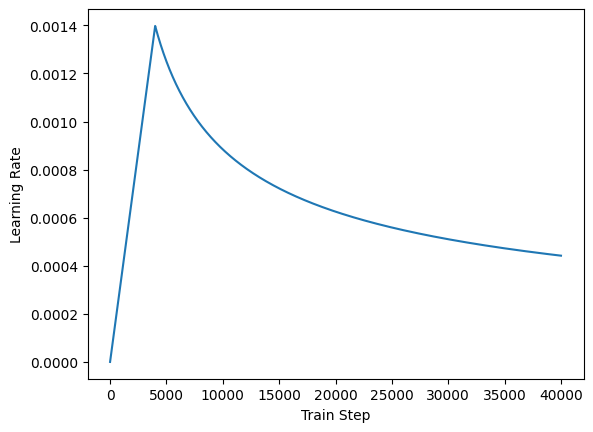

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask


In [ ]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [ ]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp,
            True,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
import pickle
with open('accuracies.pkl', 'rb') as f:
  accuracies = pickle.load(f)
with open('losses.pkl', 'rb') as f:
  losses = pickle.load(f)

FileNotFoundError: ignored

In [ ]:
with tf.device("/device:gpu:1"):
  # accuracies = []
  # losses = []
  for epoch in range(30):
      start = time.time()

      train_loss.reset_states()

      for (batch, (inp, tar)) in enumerate(dataset):
          train_step(inp, tar)

          if batch % 200 == 0:
              print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
              accuracies.append(train_accuracy.result())
              losses.append(train_loss.result())

      if (epoch + 1) % 5 == 0:
          ckpt_save_path = ckpt_manager.save()
          print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))

      print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.0100 Accuracy 0.9094
Epoch 1 Loss 0.0143 Accuracy 0.9097
Time taken for 1 epoch: 2.324597120285034 secs

Epoch 2 Batch 0 Loss 0.0157 Accuracy 0.9097
Epoch 2 Loss 0.0142 Accuracy 0.9100
Time taken for 1 epoch: 2.4462838172912598 secs

Epoch 3 Batch 0 Loss 0.0043 Accuracy 0.9100
Epoch 3 Loss 0.0137 Accuracy 0.9103
Time taken for 1 epoch: 2.5110459327697754 secs

Epoch 4 Batch 0 Loss 0.0133 Accuracy 0.9103
Epoch 4 Loss 0.0172 Accuracy 0.9105
Time taken for 1 epoch: 2.3075761795043945 secs

Epoch 5 Batch 0 Loss 0.0140 Accuracy 0.9105
Saving checkpoint for epoch 5 at checkpoints/ckpt-59
Epoch 5 Loss 0.0141 Accuracy 0.9108
Time taken for 1 epoch: 2.758171558380127 secs

Epoch 6 Batch 0 Loss 0.0064 Accuracy 0.9108
Epoch 6 Loss 0.0156 Accuracy 0.9111
Time taken for 1 epoch: 2.376807928085327 secs

Epoch 7 Batch 0 Loss 0.0173 Accuracy 0.9111
Epoch 7 Loss 0.0155 Accuracy 0.9114
Time taken for 1 epoch: 2.4114034175872803 secs

Epoch 8 Batch 0 Loss 0.0208 Accuracy 0.9114
Epo

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 102)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

ax1.plot(epochs, accuracies, 'b', label='Accuracy')
ax1.set_title('Accuracy vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()


ax2.plot(epochs, losses, 'r', label='Loss')
ax2.set_title('Loss vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()


plt.tight_layout()

plt.show()


In [ ]:
with open("/content/MyDrive/MyDrive/accuracies.pkl", "wb") as f:
  pickle.dump(accuracies, f)
with open("/content/MyDrive/MyDrive/losses.pkl", "wb") as f:


# **Saving**

In [ ]:
!zip -r checkpoints_next_day.zip checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/ckpt-27.data-00000-of-00001 (deflated 12%)
  adding: checkpoints/ckpt-26.index (deflated 80%)
  adding: checkpoints/ckpt-27.index (deflated 80%)
  adding: checkpoints/ckpt-25.index (deflated 80%)
  adding: checkpoints/checkpoint (deflated 72%)
  adding: checkpoints/ckpt-26.data-00000-of-00001 (deflated 12%)
  adding: checkpoints/ckpt-23.data-00000-of-00001 (deflated 12%)
  adding: checkpoints/ckpt-24.index (deflated 80%)
  adding: checkpoints/ckpt-23.index (deflated 80%)
  adding: checkpoints/ckpt-25.data-00000-of-00001 (deflated 12%)
  adding: checkpoints/ckpt-24.data-00000-of-00001 (deflated 12%)


In [ ]:
!cp   /content/drive/MyDrive/checkpoints_convs.zip .

In [ ]:
import shutil
shutil.rmtree("checkpoints")

In [ ]:
!mkdir checkpoint

In [ ]:
!cp /content/MyDrive/MyDrive/checkpoints_convs.zip .

In [ ]:
!mv /content/MyDrive/MyDrive/checkpoints.zip .

In [ ]:
from zipfile import ZipFile
with ZipFile('./checkpoints_convs.zip') as f:
  f.extractall('.')

In [ ]:
ckpt1 = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

In [ ]:
!ls ./checkpoints_old/checkpoints

checkpoint  ckpt-1.data-00000-of-00001	ckpt-1.index  ckpt-2.data-00000-of-00001  ckpt-2.index


In [ ]:
path = './checkpoints/ckpt-64'
ckpt1.restore(path)

In [ ]:
restored = ckpt1.transformer

In [ ]:
restored_opt = ckpt1.optimizer

In [ ]:
!mv checkpoints.zip /content/MyDrive/MyDrive/GPT4All/

In [ ]:
!mv Hindi_English_Truncated_Corpus.csv /content/MyDrive/MyDrive/

# **BLEU Score**

In [ ]:
!pip install nltk

In [ ]:
def evaluate(text):
    text = eng_tokenizer.texts_to_sequences([text])
    text = tf.keras.preprocessing.sequence.pad_sequences(text, maxlen=E_LENGTH,
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(text[0], 0)

    decoder_input = [hind_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(D_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = restored(
            encoder_input,
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == hind_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def translate(eng_text):
    hind_text = evaluate(text=eng_text)[0].numpy()
    hind_text = np.expand_dims(hind_text[1:], 0)
    return hind_tokenizer.sequences_to_texts(hind_text)[0]

In [ ]:
translate("Clare college is nice and it is located in the west. Would you like more information on it?")

'क्लेयर कॉलेज अच्छा है और यह पश्चिम में स्थित है क्या आप इसके बारे में अधिक जानकारी चाहते हैं'

In [ ]:
translate("I take all the little pieces and I put the pieces together like a puzzle")

'मैं लगभग बिस्तरां और नाश्ता की व्यवस्था कर रहा हूँ क्या मैं 0 स्टार एक प्रकार की प्राथमिकता है'

In [ ]:
translate("I want to go to market")

'मैं निकलना चाहता हूँ। हम देर सेवा करने के लिए जाना चाहते हैं जो निकलना चाहते हैं'

In [ ]:
import random
for i in random.sample(list(eng_test['english']), 10):
  print("English: " + i)
  print("Hindi : " + translate(i) + "\n")

English: You're welcome is there anything else I can help you with?
Hindi : आप स्वागत है क्या मैं आप के साथ अन्य कुछ मदद कर सकता है

English: Ok thats the one. Can I reserve a room for 8 people starting Saturday? We will be there 4 nights.
Hindi : ठीक है यह एक मैं शनिवार से शुरू होने वाले एक कमरा आरक्षित कर सकता हूँ हम 4 रातों के लिए बुधवार से शुरू होगा

English: That is all thank you very much.
Hindi : यह सब बहुत धन्यवाद है। बहुत धन्यवाद है। बहुत बहुत छोड़ता है। बहुत बहुत बहुत छोड़ता है।

English: Certainly. May I ask where you want to depart from?
Hindi : निश्चित रूप से मैं पूछ सकता हूँ कि आप कहाँ से निकलना चाहते हैं

English: Yes and please give me the reference number.
Hindi : हाँ कृपया मुझे संदर्भ संख्या दें।

English: I would like to find a cheap restaurant in the centre.


KeyboardInterrupt: ignored

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [ ]:
reference_translations = list(hin_test)

In [ ]:
list(hin_test)[:10]

['हाँ जब तक कि यह सस्ती कीमतों के दायरे में आता है कृपया।',
 'कैमबॉट्स का पता है Plough Green end Fen Ditton। रेस्तरां के बारे में मैं एक शानदार चीनी रेस्तरां ब्रिटिश Cuisine और कैमबॉट्स स्थान के पास एक उच्चस्तरीय गैस्ट्रोpub दिखा रहा हूँ।',
 'मैं शहर के पूर्वी भाग में एक मध्यम मूल्य पर रेस्टोरेंट चाहता हूँ',
 'रेस्तरां एक सात भी शहर के मध्य में मध्यम मूल्य पर ब्रिटिश खाना है और वे आपकी आरक्षण को पूरा करने के लिए सक्षम हैं।',
 'धन्यवाद मुझे भी दो स्थानों के बीच एक टैक्सी ले जाना चाहिए।',
 'मैं सोने के घर के लिए एक टैक्सी की मांग करूंगा।',
 'तो क्या कोई संग्रहालय है?',
 'मैं शहर के उत्तर में एक तालाब कहाँ ढूंढ सकता हूँ?',
 'यह बहुत अच्छा है. मैं भी एक होटल के बारे में जानना चाहता हूँ जो घर से घर कहा जाता है. आप इसे मेरे लिए ढूंढ सकते हैं.',
 'केन्द्र में 69 रेस्तरां हैं। क्या मैं इसे आपके लिए मूल्य के आधार पर संकुचित कर सकता हूँ?']

In [ ]:
eng_test[:10]

,Unnamed: 0,english
205,205,Yes as long as it falls in the cheap price range please.
2805,2805,Camboats address is The Plough Green end Fen Ditton. Regarding restaurants I am showing an elegant Chinese restaurant British Cuisine and an upscale Gastropub near the Camboats location.
1114,1114,I would like a moderately priced restaurant in the east part of town
2107,2107,Restaurant one seven is also British cuisine moderate priced in the center of town and they are able to accommodate your reservation.
411,411,Thank you I also need to get a taxi between the two places please.
2227,2227,I'll be requesting a taxi to golden house please
3997,3997,Is there a museum then?
1852,1852,Where can I find a swimming pool in the north of town?
1100,1100,That is great. I also want to know about a hotel called home from home. Can you find it for me.
762,762,There are 69 restaurants in the centre. Can I narrow it down by price for you?


In [ ]:
from tqdm import tqdm
with tf.device("/device:gpu:1"):
  reference_translations = list(hin_test)
  candidate_translations = []
  ref = list(eng_test['english'])
  bar = tqdm(range(len(reference_translations)))
  for i in range(len(ref)):
    candidate_translations.append(translate(ref[i]))
    bar.update(1)



In [ ]:
import pickle
with open('/content/MyDrive/MyDrive/candidate_translations.pkl', 'wb') as f:
  pickle.dump(candidate_translations, f)

In [ ]:
eng_test[:10]

,Unnamed: 0,english
205,205,Yes as long as it falls in the cheap price range please.
2805,2805,Camboats address is The Plough Green end Fen Ditton. Regarding restaurants I am showing an elegant Chinese restaurant British Cuisine and an upscale Gastropub near the Camboats location.
1114,1114,I would like a moderately priced restaurant in the east part of town
2107,2107,Restaurant one seven is also British cuisine moderate priced in the center of town and they are able to accommodate your reservation.
411,411,Thank you I also need to get a taxi between the two places please.
2227,2227,I'll be requesting a taxi to golden house please
3997,3997,Is there a museum then?
1852,1852,Where can I find a swimming pool in the north of town?
1100,1100,That is great. I also want to know about a hotel called home from home. Can you find it for me.
762,762,There are 69 restaurants in the centre. Can I narrow it down by price for you?


In [ ]:
candidate_translations[:10]

['हाँ जब तक यह सस्ते दामों में एक महंगा मूल्य श्रेणी में कृपया।',
 'प्लो हरित अंत फ़ेन डेटन एक रेस्तरां है मैं रेस्तरां के लिए के प्रकार के भोजन प्रदान करता हूँ एक ब्रिटिश खाना प्रदान करने के लिए एक ब्रिटिश खाना सेवा करता है और हमें एक मैंने संपर्क संख्या el0wi0zv है',
 'मैं शहर के पूर्वी भाग में एक मध्यम मूल्य पर रेस्टोरेंट चाहता हूं।',
 'रेस्तरां शहर के मध्य में एक मध्यम मूल्य पर ब्रिटिश भोजन भी ढूंढ रहा है वे 15 को संकुचित करना चाहते हैं और आप अपने आरक्षण करने के लिए',
 'धन्यवाद मुझे भी दोनों स्थानों के बीच ले जाने के लिए एक टैक्सी की जरूरत है।',
 'मैं एक टैक्सी चाहता हूँ।',
 'क्या वहाँ एक संग्रहालय है तो वहाँ एक संग्रहालय है तो वहाँ एक संग्रहालय है',
 'मैं शहर के उत्तरी में एक तालाब ढूंढना चाहता हूं।',
 'जो भी नाम के बारे में जानकारी के बारे में भी जानना चाहता हूँ नाम से नाम के लिए मुझे मिल सकता है',
 'मध्य में अगले खाने के लिए मेरे लिए कह रहा है जिसके लिए मैंने इसे थोड़ा पहले की कीमत के लिए कर सकता है।']

In [ ]:
reference_translations[:10]

['हाँ जब तक कि यह सस्ती कीमतों के दायरे में आता है कृपया।',
 'कैमबॉट्स का पता है Plough Green end Fen Ditton। रेस्तरां के बारे में मैं एक शानदार चीनी रेस्तरां ब्रिटिश Cuisine और कैमबॉट्स स्थान के पास एक उच्चस्तरीय गैस्ट्रोpub दिखा रहा हूँ।',
 'मैं शहर के पूर्वी भाग में एक मध्यम मूल्य पर रेस्टोरेंट चाहता हूँ',
 'रेस्तरां एक सात भी शहर के मध्य में मध्यम मूल्य पर ब्रिटिश खाना है और वे आपकी आरक्षण को पूरा करने के लिए सक्षम हैं।',
 'धन्यवाद मुझे भी दो स्थानों के बीच एक टैक्सी ले जाना चाहिए।',
 'मैं सोने के घर के लिए एक टैक्सी की मांग करूंगा।',
 'तो क्या कोई संग्रहालय है?',
 'मैं शहर के उत्तर में एक तालाब कहाँ ढूंढ सकता हूँ?',
 'यह बहुत अच्छा है. मैं भी एक होटल के बारे में जानना चाहता हूँ जो घर से घर कहा जाता है. आप इसे मेरे लिए ढूंढ सकते हैं.',
 'केन्द्र में 69 रेस्तरां हैं। क्या मैं इसे आपके लिए मूल्य के आधार पर संकुचित कर सकता हूँ?']

In [ ]:
def filter_func(txt):
  return ''.join(list(filter(lambda x: x not in filters, txt)))


In [ ]:
filtered = [filter_func(i) for i in reference_translations]

In [ ]:
filtered

In [ ]:
candidate_translations

In [ ]:
ref_translations = [reference.split() for reference in filtered]

In [ ]:
ref_translations

In [ ]:
bleu = corpus_bleu(ref_translations, candidate_translations)

In [ ]:
print(f"The corpus bleu score is {bleu}")

The corpus bleu score is 0.21211179448595513


In [ ]:
!zip -r checkpoints_convs.zip checkpoints

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/ckpt-60.data-00000-of-00001 (deflated 7%)
  adding: checkpoints/ckpt-64.data-00000-of-00001 (deflated 7%)
  adding: checkpoints/ckpt-62.data-00000-of-00001 (deflated 7%)
  adding: checkpoints/ckpt-63.index (deflated 80%)
  adding: checkpoints/ckpt-60.index (deflated 80%)
  adding: checkpoints/checkpoint (deflated 72%)
  adding: checkpoints/ckpt-64.index (deflated 80%)
  adding: checkpoints/ckpt-62.index (deflated 80%)
  adding: checkpoints/ckpt-61.index (deflated 80%)
  adding: checkpoints/ckpt-63.data-00000-of-00001 (deflated 7%)
  adding: checkpoints/ckpt-61.data-00000-of-00001 (deflated 7%)
